In [29]:
# ===============================
# ✅ SETUP
# ===============================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.vgg import vgg16
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from PIL import Image
import glob
import numpy as np

In [42]:
# ===============================
# ✅ CONFIG
# ===============================
class Config:
    lowlight_images_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lol_Dataset/Data/lol_dataset/train/low"
    snapshots_folder = "/content/snapshots/"
    lr = 0.0001
    weight_decay = 0.0001
    grad_clip_norm = 0.1
    num_epochs = 100
    train_batch_size = 4
    num_workers = 2
    display_iter = 5
    snapshot_iter = 50
    load_pretrain = False
    pretrain_dir = "/content/snapshots/Epoch99.pth"

In [43]:
config = Config()
os.makedirs(config.snapshots_folder, exist_ok=True)

In [44]:
# ===============================
# ✅ DATASET CLASS
# ===============================
class LowlightDataset(Dataset):
    def __init__(self, image_dir, size=256):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img = Image.open(self.image_paths[index]).convert("RGB")
        img = img.resize((self.size, self.size), Image.Resampling.LANCZOS)
        img = np.asarray(img) / 255.0
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
        return img_tensor


In [45]:
# ===============================
# ✅ LOSS FUNCTIONS (Original)
# ===============================
class L_color(nn.Module):
    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x):
        mean_rgb = torch.mean(x, [2, 3], keepdim=True)
        mr, mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = (mr - mg) ** 2
        Drb = (mr - mb) ** 2
        Dgb = (mb - mg) ** 2
        k = torch.sqrt(Drg ** 2 + Drb ** 2 + Dgb ** 2)
        return k

class L_spa(nn.Module):
    def __init__(self):
        super(L_spa, self).__init__()
        self.weight_left = nn.Parameter(torch.tensor([[0, 0, 0], [-1, 1, 0], [0, 0, 0]]).float().cuda().unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.weight_right = nn.Parameter(torch.tensor([[0, 0, 0], [0, 1, -1], [0, 0, 0]]).float().cuda().unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.weight_up = nn.Parameter(torch.tensor([[0, -1, 0], [0, 1, 0], [0, 0, 0]]).float().cuda().unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.weight_down = nn.Parameter(torch.tensor([[0, 0, 0], [0, 1, 0], [0, -1, 0]]).float().cuda().unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.pool = nn.AvgPool2d(4)

    def forward(self, org, enhance):
        org_mean = torch.mean(org, 1, keepdim=True)
        enhance_mean = torch.mean(enhance, 1, keepdim=True)
        org_pool = self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        D_left = (F.conv2d(org_pool, self.weight_left, padding=1) - F.conv2d(enhance_pool, self.weight_left, padding=1)) ** 2
        D_right = (F.conv2d(org_pool, self.weight_right, padding=1) - F.conv2d(enhance_pool, self.weight_right, padding=1)) ** 2
        D_up = (F.conv2d(org_pool, self.weight_up, padding=1) - F.conv2d(enhance_pool, self.weight_up, padding=1)) ** 2
        D_down = (F.conv2d(org_pool, self.weight_down, padding=1) - F.conv2d(enhance_pool, self.weight_down, padding=1)) ** 2

        return D_left + D_right + D_up + D_down

class L_exp(nn.Module):
    def __init__(self, patch_size, mean_val):
        super(L_exp, self).__init__()
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val

    def forward(self, x):
        mean = self.pool(torch.mean(x, 1, keepdim=True))
        return torch.mean((mean - self.mean_val) ** 2)

class L_TV(nn.Module):
    def __init__(self, TVLoss_weight=1):
        super(L_TV, self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self, x):
        h_x, w_x = x.size(2), x.size(3)
        count_h = (h_x - 1) * w_x
        count_w = h_x * (w_x - 1)
        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :-1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :-1], 2).sum()
        return self.TVLoss_weight * 2 * (h_tv / count_h + w_tv / count_w) / x.size(0)

class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()

    def forward(self, x):
        mean_rgb = torch.mean(x, [2, 3], keepdim=True)
        mr, mg, mb = torch.split(mean_rgb, 1, dim=1)
        r, g, b = torch.split(x, 1, dim=1)
        Dr, Dg, Db = r - mr, g - mg, b - mb
        k = torch.sqrt(Dr**2 + Dg**2 + Db**2)
        return torch.mean(k)

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        features = vgg16(pretrained=True).features
        self.vgg_layers = nn.Sequential(*[features[i] for i in range(23)])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.vgg_layers(x)


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
#import pytorch_colors as colors
import numpy as np

class enhance_net_nopool(nn.Module):

	def __init__(self):
		super(enhance_net_nopool, self).__init__()

		self.relu = nn.ReLU(inplace=True)

		number_f = 32
		self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True)
		self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True)

		self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
		self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)



	def forward(self, x):

		x1 = self.relu(self.e_conv1(x))
		# p1 = self.maxpool(x1)
		x2 = self.relu(self.e_conv2(x1))
		# p2 = self.maxpool(x2)
		x3 = self.relu(self.e_conv3(x2))
		# p3 = self.maxpool(x3)
		x4 = self.relu(self.e_conv4(x3))

		x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
		# x5 = self.upsample(x5)
		x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

		x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
		r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)


		x = x + r1*(torch.pow(x,2)-x)
		x = x + r2*(torch.pow(x,2)-x)
		x = x + r3*(torch.pow(x,2)-x)
		enhance_image_1 = x + r4*(torch.pow(x,2)-x)
		x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
		x = x + r6*(torch.pow(x,2)-x)
		x = x + r7*(torch.pow(x,2)-x)
		enhance_image = x + r8*(torch.pow(x,2)-x)
		r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
		return enhance_image_1,enhance_image,r

In [47]:

# ===============================
# ✅ TRAINING (assuming enhance_net_nopool is defined)
# ===============================
# from model import enhance_net_nopool  # Replace with actual import or define here
DCE_net = enhance_net_nopool().cuda()
if config.load_pretrain:
    DCE_net.load_state_dict(torch.load(config.pretrain_dir))

DCE_net.train()
train_dataset = LowlightDataset(config.lowlight_images_path)
train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers)

L_color_loss = L_color().cuda()
L_spa_loss = L_spa().cuda()
L_exp_loss = L_exp(16, 0.6).cuda()
L_TV_loss = L_TV().cuda()
Sa_loss = Sa_Loss().cuda()

optimizer = Adam(DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)

for epoch in range(config.num_epochs):
    for iteration, img_lowlight in enumerate(train_loader):
        img_lowlight = img_lowlight.cuda()
        enhanced_1, enhanced_img, A = DCE_net(img_lowlight)

        loss_tv = 200 * L_TV_loss(A)
        loss_spa = torch.mean(L_spa_loss(img_lowlight, enhanced_img))
        loss_col = 5 * torch.mean(L_color_loss(enhanced_img))
        loss_exp = 10 * L_exp_loss(enhanced_img)

        total_loss = loss_tv + loss_spa + loss_col + loss_exp

        optimizer.zero_grad()
        total_loss.backward()
        clip_grad_norm_(DCE_net.parameters(), config.grad_clip_norm)
        optimizer.step()

        if (iteration + 1) % config.display_iter == 0:
            print(f"Epoch [{epoch+1}/{config.num_epochs}], Step [{iteration+1}], Loss: {total_loss.item():.4f}")

        if (iteration + 1) % config.snapshot_iter == 0:
            torch.save(DCE_net.state_dict(), os.path.join(config.snapshots_folder, f"Epoch{epoch+1}_Iter{iteration+1}.pth"))


Epoch [1/100], Step [5], Loss: 3.1245
Epoch [1/100], Step [10], Loss: 2.8775
Epoch [1/100], Step [15], Loss: 2.9233
Epoch [1/100], Step [20], Loss: 3.0813
Epoch [1/100], Step [25], Loss: 3.3066
Epoch [1/100], Step [30], Loss: 3.3286
Epoch [1/100], Step [35], Loss: 2.8536
Epoch [1/100], Step [40], Loss: 2.8699
Epoch [1/100], Step [45], Loss: 2.3145
Epoch [1/100], Step [50], Loss: 2.7383
Epoch [1/100], Step [55], Loss: 2.1858
Epoch [1/100], Step [60], Loss: 2.2310
Epoch [1/100], Step [65], Loss: 2.2671
Epoch [1/100], Step [70], Loss: 2.1249
Epoch [1/100], Step [75], Loss: 1.7599
Epoch [1/100], Step [80], Loss: 2.0630
Epoch [1/100], Step [85], Loss: 2.3145
Epoch [1/100], Step [90], Loss: 1.9535
Epoch [1/100], Step [95], Loss: 1.2502
Epoch [1/100], Step [100], Loss: 1.9857
Epoch [1/100], Step [105], Loss: 2.0248
Epoch [1/100], Step [110], Loss: 1.2524
Epoch [1/100], Step [115], Loss: 1.5604
Epoch [1/100], Step [120], Loss: 0.7219
Epoch [2/100], Step [5], Loss: 1.1389
Epoch [2/100], Step [1

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load('/content/snapshots/Epoch9_Iter100.pth', map_location=device))
model.eval()


enhance_net_nopool(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv7): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
)

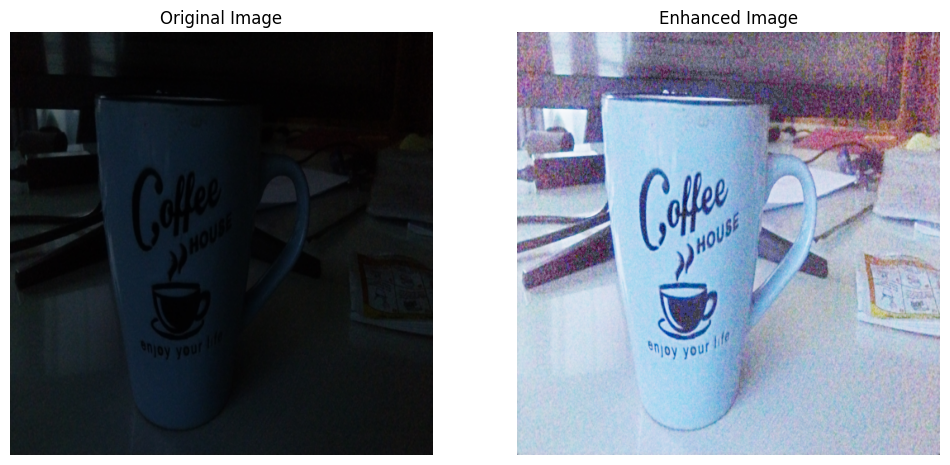

In [52]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess test image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

img = Image.open('/content/cup.jpg').convert('RGB')  # Replace with your file path
input_img = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]

# Forward pass through the model
with torch.no_grad():
    enhance_image_1, enhance_image, r = model(input_img)

output_img = enhance_image  # final enhanced image from the model

# Convert tensors to numpy images for display
original_np = input_img.squeeze().permute(1, 2, 0).cpu().numpy()
enhanced_np = output_img.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(enhanced_np)
axes[1].set_title('Enhanced Image')
axes[1].axis('off')

plt.show()
